### 0.1 Cell Clearence

Code for removing unwanted variables taking up memory space

In [1]:
## lists all the variables taking up memory space

import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i1:  646.0 B
                           _oh:  232.0 B
                           Out:  232.0 B
                          open:  136.0 B
                    sizeof_fmt:  136.0 B
                           _ih:  120.0 B
                            In:  120.0 B
                       __doc__:  113.0 B
                   __builtin__:   72.0 B
                  __builtins__:   72.0 B


In [2]:
import gc
gc.collect()

35

In [3]:
## magic function that clears all the variables from the current namespace
%reset -f

### 0.2 Imports

Important packages and files to install everytime you restart your kernel or relaunch the server

In [5]:
%%bash
pip install scprep
pip install scanpy
pip install phate
pip install umap-learn
pip install phenograph
pip install --upgrade matplotlib
pip install harmonypy

  Using cached scprep-1.2.3-py3-none-any.whl (94 kB)
  Using cached scanpy-1.9.6-py3-none-any.whl (2.0 MB)
  Using cached get_annotations-0.1.2-py3-none-any.whl (4.5 kB)
  Using cached anndata-0.10.3-py3-none-any.whl (119 kB)
  Using cached umap_learn-0.5.5-py3-none-any.whl
  Using cached numba-0.58.1-cp39-cp39-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)
  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
  Using cached array_api_compat-1.4-py3-none-any.whl (29 kB)
  Using cached llvmlite-0.41.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.6 MB)
  Using cached pynndescent-0.5.11-py3-none-any.whl (55 kB)
  Using cached stdlib_list-0.10.0-py3-none-any.whl (79 kB)
  Using cached phate-1.0.11-py3-none-any.whl (23 kB)
  Using cached s_gd2-1.8.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (417 kB)
  Using cached graphtools-1.5.3-py3-none-any.whl (45 kB)
  Using

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allensdk 2.13.6 requires matplotlib<3.4.3,>=1.4.3, but you have matplotlib 3.8.2 which is incompatible.


  Using cached harmonypy-0.0.9-py3-none-any.whl (20 kB)


In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scprep, phate, umap 
import anndata as ad
import tasklogger
import phenograph
import sklearn
import sklearn.cluster
import sklearn.manifold
import graphtools as gt
import matplotlib.pyplot as plt
import harmonypy
from scipy.io import mmread

import gzip
from scipy.sparse import save_npz
from scipy.sparse import load_npz

%matplotlib inline 

## 1. DATA PREPROCESSING

### 1.1 Loading data

I used gzip to open it the first time and stored it as a npz file for faster loading into the kernel

The data does not come with genes and barcodes embedded in it and since the data was too big I had to download them seperately and edit them side by side with the expression data through the preprocessing steps until I filtered them small enough that I could combine it into a dataframe

In [2]:
# mtx_file_path = 'endocrine.counts.mtx.gz'

# with gzip.open(mtx_file_path, 'rb') as mtx_file:
#     expression_data_csr = mmread(mtx_file).tocsr()
    
# save_npz("unfiltered_data.npz", expression_data_csr)

In [3]:
data = load_npz("unfiltered_data.npz")
data = data.T

genes = pd.read_csv("features.tsv", header=None, sep='\t')
barcodes = pd.read_csv("barcodes.tsv.gz", header=None, sep='\t')

metadata = pd.read_csv('endocrine.metadata.tsv', sep='\t', index_col=0)
metadata = metadata[1:] #removing the first row as it had an extra header

**Visualising the data**

In [8]:
data.shape

(46261, 20621)

In [4]:
genes = genes.iloc[:,1:2]
genes.head()

1
0   OR4F5
1  OR4F29
2  OR4F16
3  SAMD11
4   NOC2L

In [10]:
barcodes.head()

0
0  S5.DT_AACTCAGTCGGTCTAA
1  S5.DT_AACTGGTGTTGTCTTT
2  S5.DT_AAGTCTGGTTATCACG
3  S5.DT_ACAGCCGAGTGTTTGC
4  S5.DT_ACGCCAGGTCTGCAAT

In [4]:
# Subsetting the metadata DataFrame to include only the relevant columns
metadata = metadata[["biosample_id", "donor_id", "sex"]]

def extract_prefix(biosample_id):
    return biosample_id.split('.')[0]

# celltype contains information from biosample_id 
metadata['celltype'] = metadata['biosample_id'].apply(extract_prefix)
metadata.head()

biosample_id donor_id      sex celltype
NAME                                                          
S5.DT_AACTCAGTCGGTCTAA        S5.DT       H1  unknown       S5
S5.DT_AACTGGTGTTGTCTTT        S5.DT       H1  unknown       S5
S5.DT_AAGTCTGGTTATCACG        S5.DT       H1  unknown       S5
S5.DT_ACAGCCGAGTGTTTGC        S5.DT       H1  unknown       S5
S5.DT_ACGCCAGGTCTGCAAT        S5.DT       H1  unknown       S5

### 1.2 Library size filtering

The dataset appears robust on its own. I selected percentiles such that a minimum expression of around 100 cells on both sides we present, effectively filtering out data below 10^2 cells. Given that we’ll utilize only 15% of the current dataset through random selection, we can enhance our selection criteria. Notably, the paper employed a threshold, excluding cells with less than 1000 UMI counts.

In [12]:
percentiles = (1, 99)
scprep.plot.plot_library_size(data, percentile=percentiles)

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [5]:
percentiles = (1, 99)
data, barcodes, metadata = scprep.filter.filter_library_size(data, barcodes, metadata, percentile=percentiles)
data.shape

(45335, 20621)

#### NOTE: Removing Empty Column and Rows

There shouldnt be any after the last step but it does not hurt to be safe

In [ ]:
data = scprep.filter.filter_empty_cells(data)
data = scprep.filter.filter_empty_genes(data)

#### NOTE: Filtering Duplicates and Cells with High Mitochondrial Count

I wanted to also filter the duplicates using scprep.filter.filter_duplicates but the kernel crashes so I am skipping that for now, also there was no mitochondrial gene count present so I couldnt filter out those datapoints with high mt counts

#### NOTE: Batch correction

From the paper, we know that Harmony was used in the paper to correct for batch effects with 'sample' as the covariate, which suggests that each sample could be treated as a batch. Looking at the metadata file, we can see that the biosample_id column contains the sample information. Batch correction is done after pca so we will also do the same. (Confirmed that this approach can be taken with Prof. Leareau on 12/11)

In [ ]:
# data, barcodes[0] = scprep.filter.filter_duplicates(data, barcodes[0])
# mt_genes = scprep.select.get_gene_set(data, starts_with="MT")
## mt_genes had 0 genes

### 1.3 Filtering Out Rare Genes

In [6]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff = 25,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

<Axes: title={'center': 'Gene capture before filtering'}, xlabel='# of cells with nonzero expression', ylabel='# of genes'>

In [6]:
data, genes[1] = scprep.filter.filter_rare_genes(data, genes[1], min_cells=25)
genes = genes.dropna(axis=0)
data.shape

(45335, 16291)

### 1.4 Dataset Desampling

I wanted to do normalisation and log transformation of the data before reducing the size of the dataset but the kernel keeps crashing and running out of memory so we will first reduce the dataset size to 7000 cells. 7000 cells because it was the maximum number of cells (dataset size) i could without crashing the kernel. Below is the code for randomly selecting 7000 datapoints from our current dataset of 45335 cells.

I also considered if the desampling must be done such that the distribution of cells in each cell type remains the same as the original dataset or if should be equal amongst all of them and I am proceeding with random sampling. (Confirmed that this approach can be taken with Prof. Leareau on 12/11)

In [7]:
np.random.seed(42)
num_cells = data.shape[0]

selected_indices = np.random.choice(num_cells, size=7000, replace=False)

data = data[selected_indices, :]
barcodes = barcodes.iloc[selected_indices]
metadata = metadata.iloc[selected_indices]

In [8]:
data = pd.DataFrame(data=data.toarray(), index=barcodes, columns=genes[1])
data

1                            SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  \
0                                                                          
A.Donor.2_TAGTAATGAGCATC          7      0       0        0      0     0   
A.Donor.8_TTATTCCTCTGTTT          0      0       0        0      0     0   
A.Donor.10_ACTCGAGAAGGCGA         0      0       0        0      0     0   
S6.A11_TCAGCTCAGGGAACGG           0      0       0        0      0     1   
S5.NEUROG3_TGCCAAATCGGGAGTA       0      0       0        0      0     0   
...                             ...    ...     ...      ...    ...   ...   
A.Donor.10_ATTACCTGGTCGAT         0      0       0        0      0     0   
M1.H1_AACTCCCCATATGGTC            0      2       0        0      0     0   
S7.exp22_TTACCATTCAACACCA         0      1       0        0      0     0   
S6.B5_GCGAGAATCCACGACG            0      0       0        0      0     0   
S7.exp23_GGAGGATCATTCTTCA         2      3       0        0      0     0   

1                            ISG15  AGRN  C1orf159  TTLL10  ...  BX004987.1  \
0                                                           ...               
A.Donor.2_TAGTAATGAGCATC         3     0         0       0  ...           0   
A.Donor.8_TTATTCCTCTGTTT         0     0         0       0  ...           0   
A.Donor.10_ACTCGAGAAGGCGA        0     0         0       0  ...           0   
S6.A11_TCAGCTCAGGGAACGG          0     1         0       0  ...           0   
S5.NEUROG3_TGCCAAATCGGGAGTA      0     0         0       0  ...           0   
...                            ...   ...       ...     ...  ...         ...   
A.Donor.10_ATTACCTGGTCGAT        1     0         0       0  ...           0   
M1.H1_AACTCCCCATATGGTC           0     0         0       0  ...           0   
S7.exp22_TTACCATTCAACACCA        0     0         0       0  ...           0   
S6.B5_GCGAGAATCCACGACG           0     0         0       1  ...           0   
S7.exp23_GGAGGATCATTCTTCA        0     0         0       0  ...           0   

1                            AC145212.1  MAFIP  AC011043.1  AL592183.1  \
0                                                                        
A.Donor.2_TAGTAATGAGCATC              0      0           0           2   
A.Donor.8_TTATTCCTCTGTTT              0      0           0           0   
A.Donor.10_ACTCGAGAAGGCGA             0      0           0           1   
S6.A11_TCAGCTCAGGGAACGG               0      0           1           0   
S5.NEUROG3_TGCCAAATCGGGAGTA           0      0           0           0   
...                                 ...    ...         ...         ...   
A.Donor.10_ATTACCTGGTCGAT             0      0           0           0   
M1.H1_AACTCCCCATATGGTC                0      0           0           0   
S7.exp22_TTACCATTCAACACCA             0      0           3           0   
S6.B5_GCGAGAATCCACGACG                0      0           0           0   
S7.exp23_GGAGGATCATTCTTCA             0      0           0           0   

1                            AC007325.4  AC007325.2  AL354822.1  AC004556.3  \
0                                                                             
A.Donor.2_TAGTAATGAGCATC              1           0           0           0   
A.Donor.8_TTATTCCTCTGTTT              1           0           0           0   
A.Donor.10_ACTCGAGAAGGCGA             1           0           0           0   
S6.A11_TCAGCTCAGGGAACGG               1           0           0           0   
S5.NEUROG3_TGCCAAATCGGGAGTA           0           0           0           0   
...                                 ...         ...         ...         ...   
A.Donor.10_ATTACCTGGTCGAT             0           0           0           0   
M1.H1_AACTCCCCATATGGTC                0           0           0           0   
S7.exp22_TTACCATTCAACACCA             0           0           0           0   
S6.B5_GCGAGAATCCACGACG                0           0           0           0   
S7.exp23_GGAGGATCATTCTTCA             1           0           0         

**checking if all the data is of the correct size**

In [11]:
print(data.shape, barcodes.shape, genes.shape, metadata.shape)

(7000, 16291) (7000,) (16291, 1) (7000, 4)


**checking and removing duplicate rows/columns**

In [12]:
duplicates = data.duplicated()
print("Duplicate row names:", data[duplicates])

Duplicate row names: Empty DataFrame
Columns: [SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, HES4, ISG15, AGRN, C1orf159, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20, ANKRD65, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, FNDC10, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, TMEM52, CFAP74, GABRD, PRKCZ, FAAP20, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, HES5, TNFRSF14, PRXL2B, MMEL1, TTC34, ACTRT2, PRDM16, ARHGEF16, MEGF6, TPRG1L, WRAP73, TP73, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, AJAP1, NPHP4, KCNAB2, CHD5, RPL22, RNF207, ICMT, GPR153, ACOT7, HES2, ESPN, TNFRSF25, PLEKHG5, NOL9, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, PER3, TNFRSF9, PARK7, ERRFI1, SLC45A1, RERE, ENO1, ...]
Index: []

[0 rows x 16291 columns]


In [13]:
duplicates = data.columns.duplicated()
print("Duplicate column names:", data.columns[duplicates])

Duplicate column names: Index(['TBCE', 'ATXN7', 'AHRR', 'MATR3', 'SOD2', 'POLR2J3', 'TMSB15B',
       'HSPA14'],
      dtype='object', name=1)


In [9]:
data = data.loc[:, ~data.columns.duplicated()]
genes = genes.loc[~genes.duplicated()]

In [10]:
print(data.shape, barcodes.shape, genes.shape, metadata.shape)

(7000, 16283) (7000,) (16283, 1) (7000, 4)


### 1.5 Library Size Normalisation

**Before**

In [24]:
scprep.plot.plot_library_size(data, title='Library size before normalization')

<Axes: title={'center': 'Library size before normalization'}, xlabel='Library size', ylabel='Number of cells'>

In [11]:
data, metadata['library_size'] = scprep.normalize.library_size_normalize(data, return_library_size=True)
print("done")

done


**After**

In [12]:
scprep.plot.plot_library_size(data, title='Library size after normalization')

<Axes: title={'center': 'Library size after normalization'}, xlabel='Library size', ylabel='Number of cells'>

### 1.6 Log Transformation

**Before**

<Axes: title={'center': 'Gene counts before transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

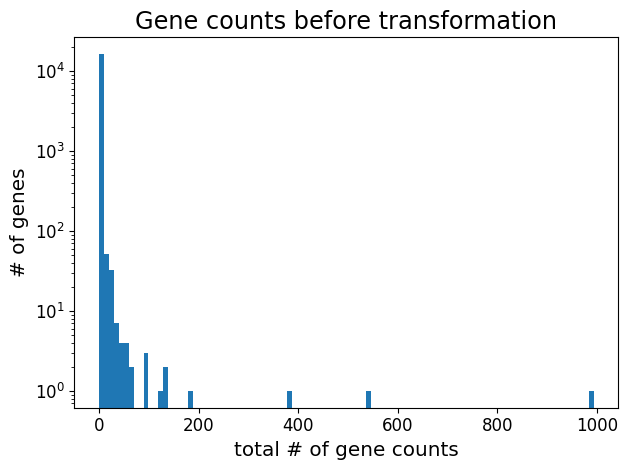

In [13]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title= 'Gene counts before transformation',
                     xlabel= 'total # of gene counts',
                     ylabel= '# of genes')

In [14]:
data = scprep.transform.sqrt(data)
print("done")

done


**After**

<Axes: title={'center': 'Gene counts after transformation'}, xlabel='total # of gene counts', ylabel='# of genes'>

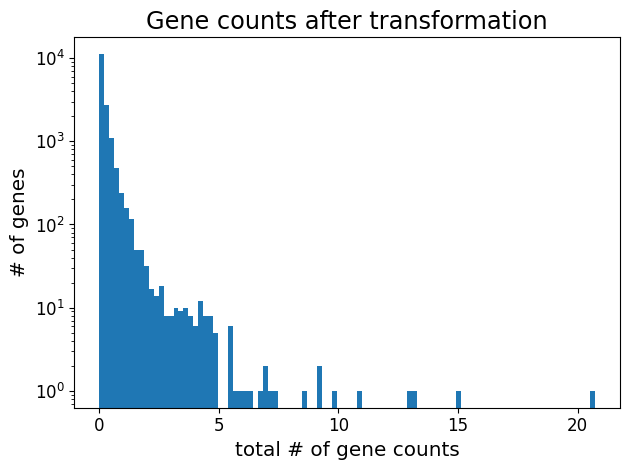

In [15]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title= 'Gene counts after transformation',
                     xlabel= 'total # of gene counts',
                     ylabel= '# of genes')

#### Saving Files For Later

In [ ]:
data.to_pickle("data.pickle.gz")
metadata.to_pickle("metadata.pickle.gz") 
# data = pd.read_pickle('data.pickle.gz')
# metadata = pd.read_pickle('metadata.pickle.gz')

## 2. DIMENTIONALITY REDUCTION

### 2.1 PCA without Batch Correction

In [16]:
data_pca = scprep.reduce.pca(data, n_components=10)

### 2.2 PCA with Batch Correction

I will be using the harmony package for performing batch correction and since it requires the dataformat to be in anndata, we will be be using that from now, it has more advantages like so and so

In [17]:
adata = ad.AnnData(X=data.values, var=pd.DataFrame(index=data.columns), obs=metadata)

In [18]:
sc.tl.pca(adata)

In [19]:
sc.external.pp.harmony_integrate(adata, key='biosample_id')

2023-12-14 03:50:41,951 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-14 03:50:49,263 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-14 03:50:49,376 - harmonypy - INFO - Iteration 1 of 10
2023-12-14 03:50:56,496 - harmonypy - INFO - Iteration 2 of 10
2023-12-14 03:51:04,167 - harmonypy - INFO - Iteration 3 of 10
2023-12-14 03:51:11,595 - harmonypy - INFO - Iteration 4 of 10
2023-12-14 03:51:18,484 - harmonypy - INFO - Iteration 5 of 10
2023-12-14 03:51:25,468 - harmonypy - INFO - Iteration 6 of 10
2023-12-14 03:51:32,667 - harmonypy - INFO - Iteration 7 of 10
2023-12-14 03:51:36,294 - harmonypy - INFO - Iteration 8 of 10
2023-12-14 03:51:40,883 - harmonypy - INFO - Iteration 9 of 10
2023-12-14 03:51:44,273 - harmonypy - INFO - Iteration 10 of 10
2023-12-14 03:51:47,404 - harmonypy - INFO - Stopped before convergence


**Visualising PCA without and with batch correction**

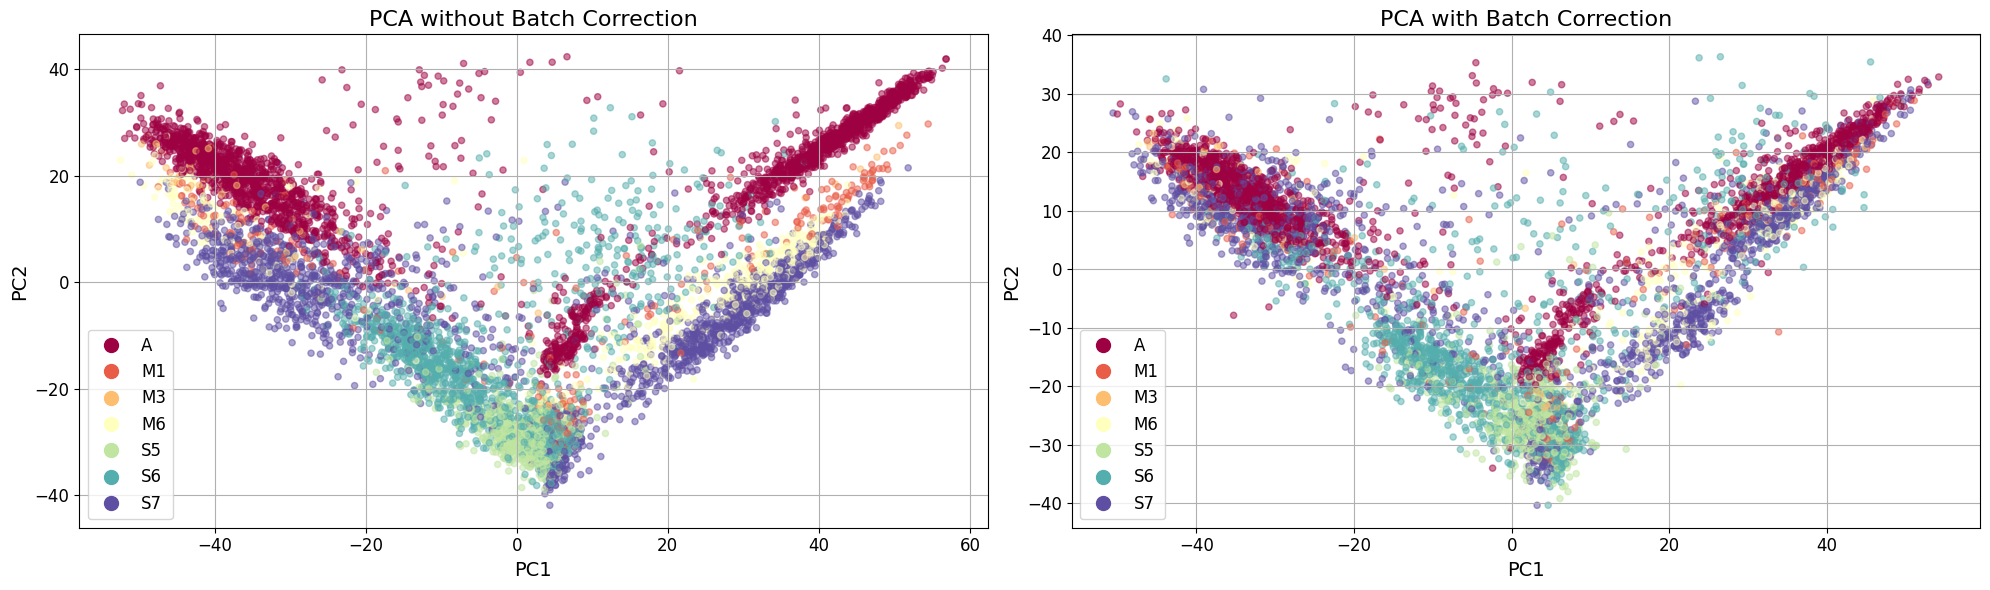

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scprep.plot.scatter2d(data_pca.iloc[:, :2], c=metadata['celltype'],
                      cmap='Spectral', ax=axes[0],
                      alpha=0.5, s=20, legend=True)
axes[0].set_title('PCA without Batch Correction', fontsize=16)
axes[0].set_xlabel('PC1', fontsize=14)
axes[0].set_ylabel('PC2', fontsize=14)
axes[0].grid(True)

scprep.plot.scatter2d(adata.obsm['X_pca_harmony'][:, :2], c=adata.obs['celltype'],
                      cmap='Spectral', ax=axes[1],
                      alpha=0.5, s=20, legend=True)
axes[1].set_title('PCA with Batch Correction', fontsize=16)
axes[1].set_xlabel('PC1', fontsize=14)
axes[1].set_ylabel('PC2', fontsize=14)
axes[1].grid(True)

fig.tight_layout()
plt.show()

**Visualising PCA under significant gene markers**

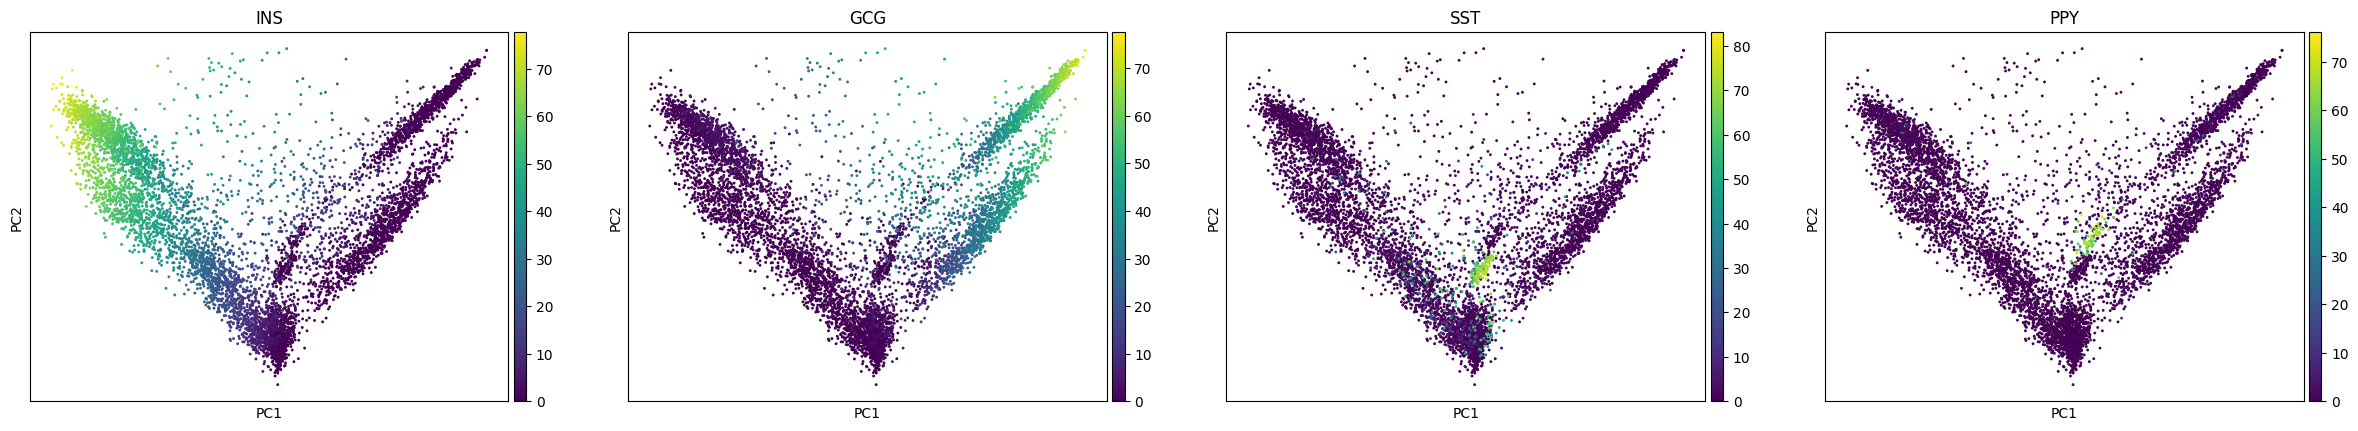

In [21]:
sc.pl.pca(adata, color=['INS','GCG','SST','PPY'])

### 2.3 UMAP Plots

/srv/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


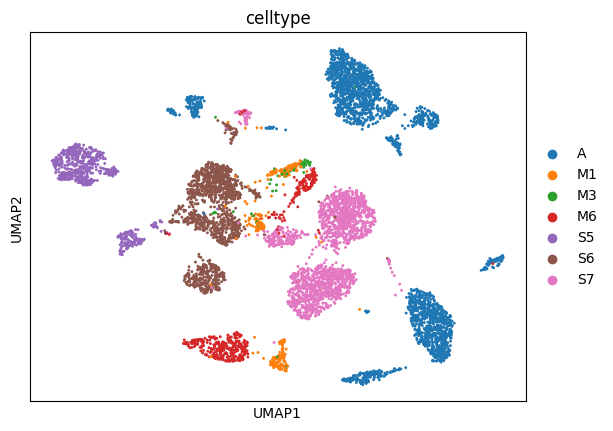

In [22]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

# Compute UMAP
sc.tl.umap(adata)

# Plot UMAP
sc.pl.umap(adata, color='celltype')

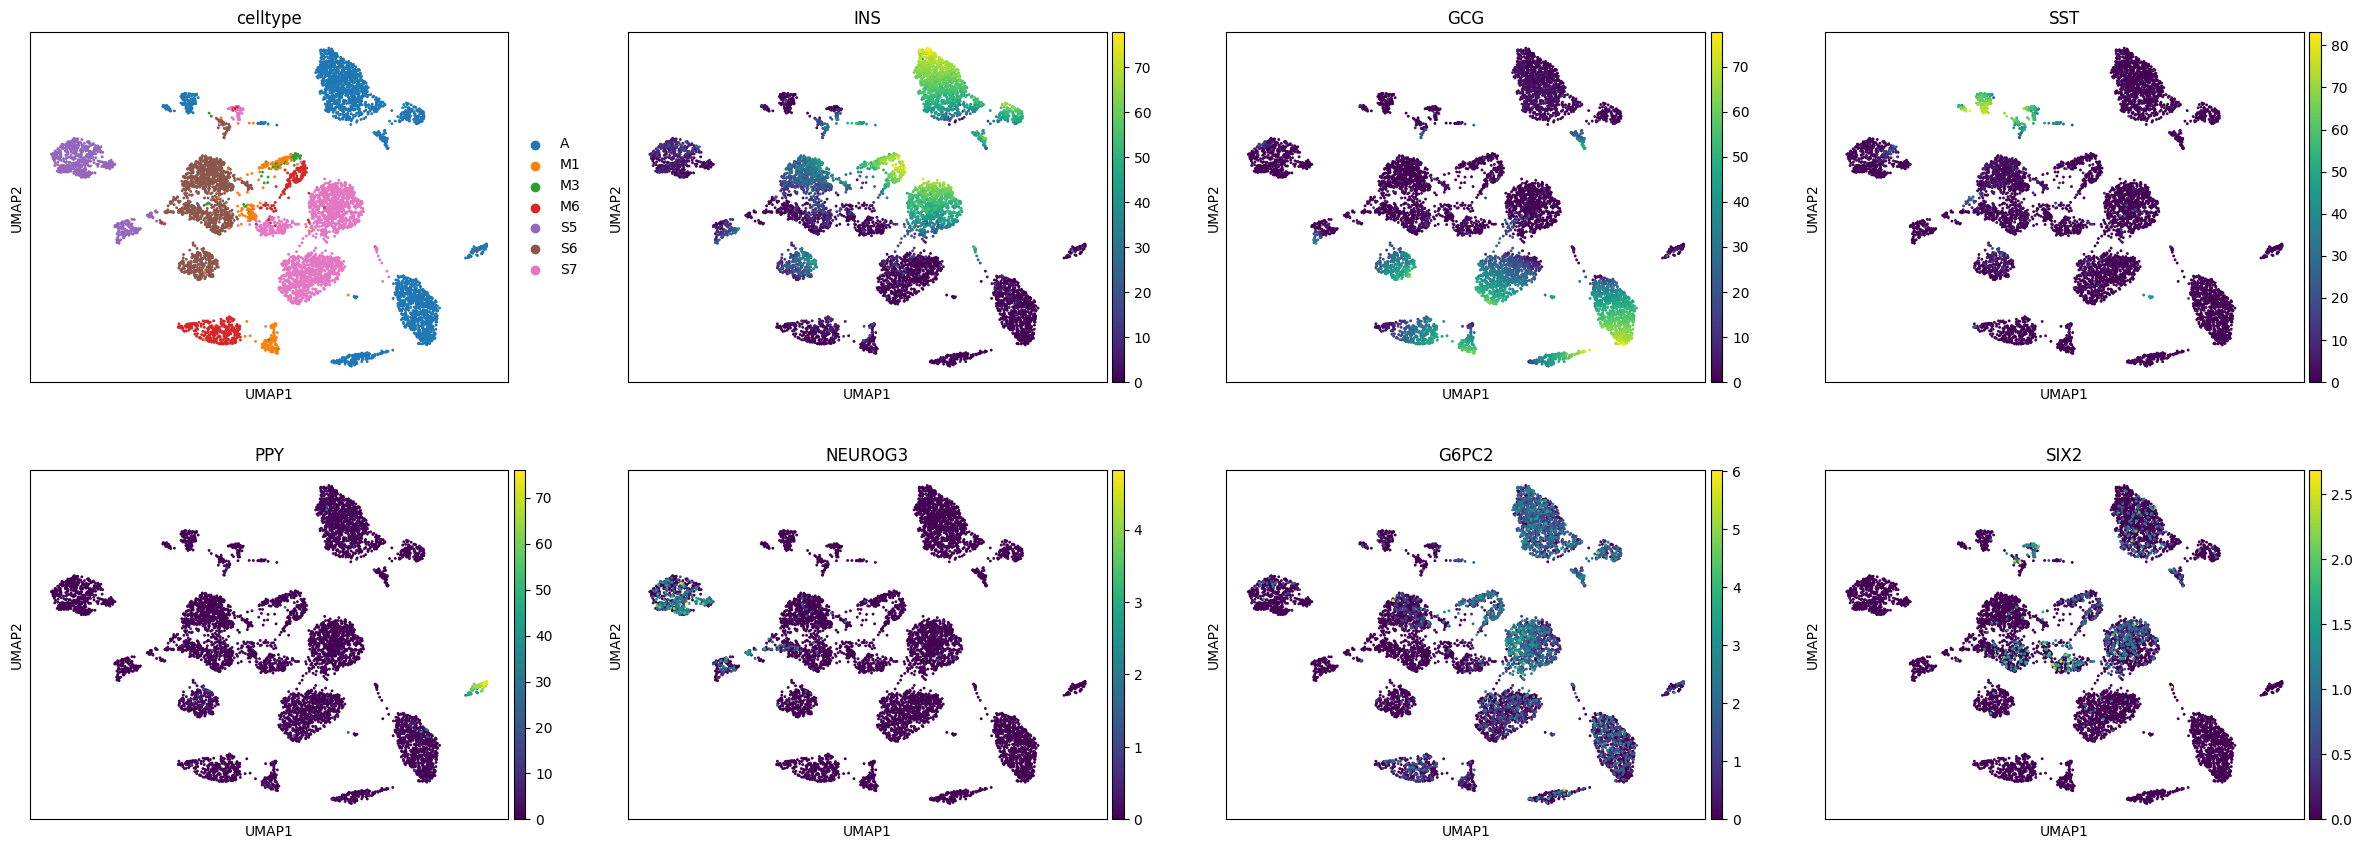

In [23]:
sc.pl.umap(adata, color=['celltype','INS','GCG','SST','PPY','NEUROG3','G6PC2','SIX2'])

### 2.4 tSNE Plots

/srv/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/srv/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


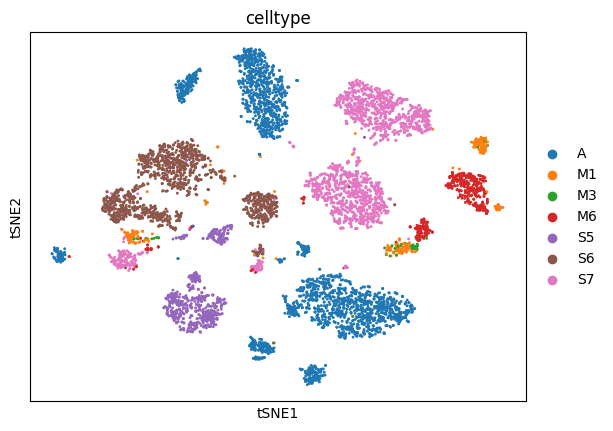

In [24]:
# Compute t-SNE
sc.tl.tsne(adata, n_pcs=50)

# Plot t-SNE
sc.pl.tsne(adata, color='celltype')

## 3. CLUSTERING

### 3.1 Phenograph vs. KMeans vs. Spectral

Taking UMAP as our dimensionality reduction method, we will proceed to find clusters

In [25]:
n_clusters = 7

with tasklogger.log_task("phenograph"):
    phenograph_clusters, _, _ = phenograph.cluster(adata.obsm["X_umap"])
    
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=n_clusters).fit_predict(adata.obsm["X_umap"])
    
G = gt.Graph(adata.obsm["X_umap"])
G_igraph = G.to_igraph()
with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters=n_clusters,affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

Calculating phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.051280975341796875 seconds
Jaccard graph constructed in 1.4712843894958496 seconds
Wrote graph to binary file in 0.26995849609375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.941324
After 9 runs, maximum modularity is Q = 0.942455
Louvain completed 29 runs in 3.9179015159606934 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.015679836273193 seconds
Calculated phenograph in 6.02 seconds.
Calculating KMeans...
Calculated KMeans in 0.22 seconds.
Calculating Spectral clustering...


/srv/conda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Calculated Spectral clustering in 17.70 seconds.


In [27]:
clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters,
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -adata.obsm["X_umap"])
    clusterings[alg] = cl_nu

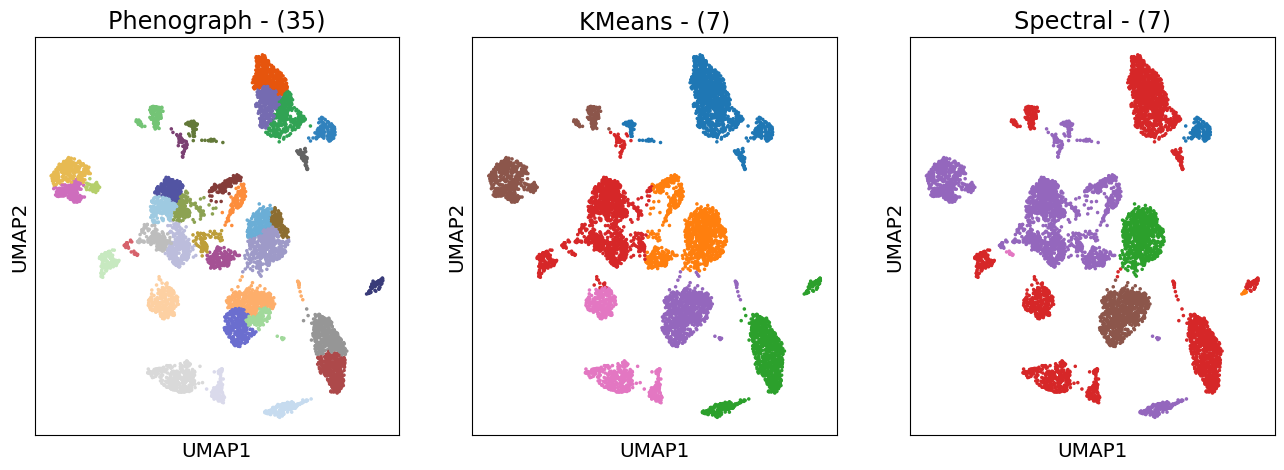

In [28]:
fig, axes = plt.subplots(1,3, figsize=(16,16), subplot_kw={'aspect':'equal'})

for ax, algorithm in zip(axes.flatten(), clusterings):
  scprep.plot.scatter2d(adata.obsm["X_umap"], c=clusterings[algorithm],
                        title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))),
                        ticks=False, label_prefix="UMAP", legend=False, discrete=True,
                        ax=ax)

### 3.2 Optimal Cluster Number

I used the below code to find the optimal cluster number (took a maximum of 10 because of time constrains).
But through the elbow graph I could deduce that a bigger cluster number would be ideal.

In the R code I have plotted another elbow plot where the significant elbows were at 5, 9 and 14. 
We shall take 14 as the figures show us that we have many umap clusters and we want to have a higher resoluted analysis.
For the elbow plot, please refer to the R code as it has elbow plot derived in another way.

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse

def get_comemberships(dat, n_clusters, model, kwargs={}):
  ## helper function
  # returns comembership matrix and model
  model = model(n_clusters=n_clusters, **kwargs)
  model.fit(dat)

  labels = model.predict(dat)
  comember = labels_to_mat(labels, n_clusters, N=dat.shape[0])

  return comember, model

def labels_to_mat(labels, n_clusters, N):
  ## helper function
  # comembership matrix helper

  # create and fill an NxN co-membership matrix
  comember = np.zeros((N, N), dtype=bool)
  for i in range(n_clusters):
    match_idx = np.where(labels==i)[0]

    # slow, memory safe (we will symmetrize + add diagonal after)
    match_idx = iter(combinations(match_idx, 2))
    for (j,k) in match_idx:
      comember[j,k] = True

  # transpose here is memory bottleneck
  comember = np.maximum(comember, comember.transpose())
  comember[np.diag_indices_from(comember)] = True

  # sparsify output for storage space
  comember = sparse.csr_matrix(comember)
  return comember

def prediction_strength(full_dat, n_clusters, n_CV=3,
                        verbose=False, model=sklearn.cluster.KMeans,
                        kwargs={}):
  test_size = 1./n_CV
  res = []
  for i in range(n_CV):
    train_dat, test_dat = train_test_split(full_dat, test_size=test_size)
    N_test = test_dat.shape[0]
    __, train_model  = get_comemberships(train_dat, n_clusters, model=model, kwargs=kwargs)
    ground_truth, __ = get_comemberships(test_dat, n_clusters, model=model, kwargs=kwargs)

    pred_labels      = labels_to_mat(train_model.predict(test_dat), n_clusters, N_test)

    # when match_count is N_test**2, there is no error
    match_count      = ground_truth.minimum(pred_labels).sum()
    res.append(match_count/(N_test**2))

  if verbose:
    print(res)

  return np.mean(res)

In [ ]:
start = 1
end   = 17

pred_strengths = []

for i in range(start, end):
  pred_strengths.append(prediction_strength(full_dat=data,
                                            n_clusters=i, n_CV=3,
                        verbose=False, model=sklearn.cluster.KMeans,
                        kwargs={}))

Text(0.5, 1.0, 'Elbow Curve for Optimal Number of Clusters')

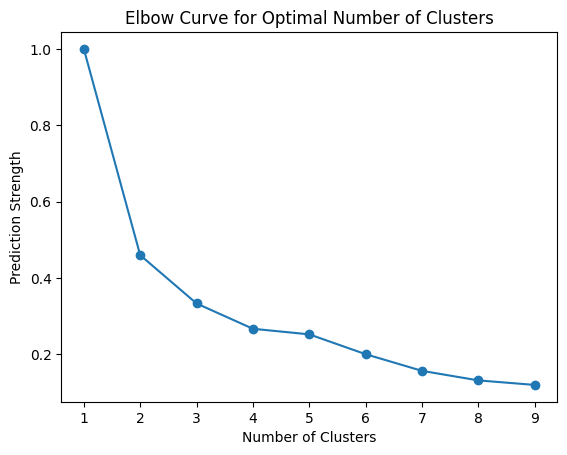

In [ ]:
n_clusters = list(range(start, end)) 
plt.plot(n_clusters, pred_strengths, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Prediction Strength')
plt.title('Elbow Curve for Optimal Number of Clusters')

In [ ]:
# Calculating differences between adjacent prediction strengths to find the highest drop in prediction
# strengths to ultimately determine the best number of clusters
differences = [pred_strengths[i] - pred_strengths[i + 1] for i in range(len(pred_strengths) - 1)]

significant_drop_index = None
max_difference = 0

for i, diff in enumerate(differences):
    print("The difference between", i+1, "and", i+2, "is", diff)

The difference between 1 and 2 is 0.540330746485213
The difference between 2 and 3 is 0.1265794544685115
The difference between 3 and 4 is 0.06631487588195506
The difference between 4 and 5 is 0.014630046942151642
The difference between 5 and 6 is 0.051959325123657946
The difference between 6 and 7 is 0.04366826762925122
The difference between 7 and 8 is 0.02499493962674884
The difference between 8 and 9 is 0.01184702522256463


**According to this plot, 7 seems like a good number to take but the 
optimal cluster number that we will be going for is 14**

### 3.3 Distance between Clusters

In [29]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])
all_clusterings = np.vstack(all_clusterings)

In [30]:
from scipy.spatial.distance import pdist, squareform
cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score))
cluster_similarities = cluster_similarities + np.eye(3)

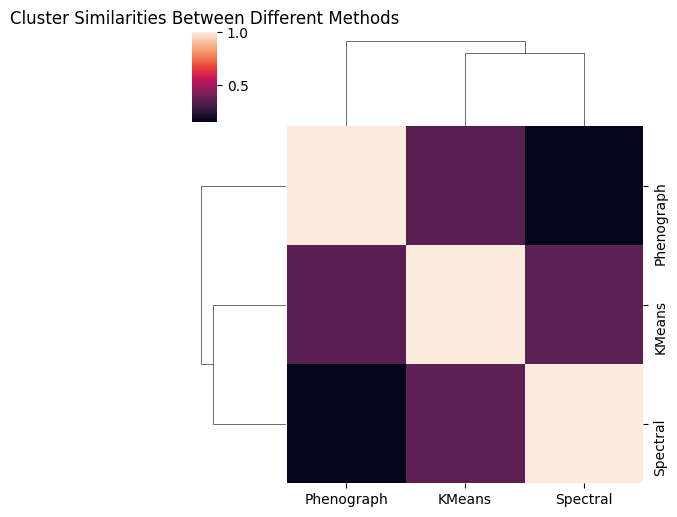

In [31]:
import seaborn as sns

sns.clustermap(cluster_similarities, xticklabels=all_algorithms, yticklabels=all_algorithms,figsize=(5, 5))
plt.title("Cluster Similarities Between Different Methods")
plt.show()

We can see that KMeans and Phenograph have the highest clustral similarity

## 4. GENE EXPRESSION ANALYSIS

### 4.1 Visualising the UMAP-KMeans Plot

In [21]:
with tasklogger.log_task("KMeans"):
    clusters = sklearn.cluster.KMeans(n_clusters=14).fit_predict(adata.obsm["X_umap"])

Calculating KMeans...
Calculated KMeans in 0.12 seconds.


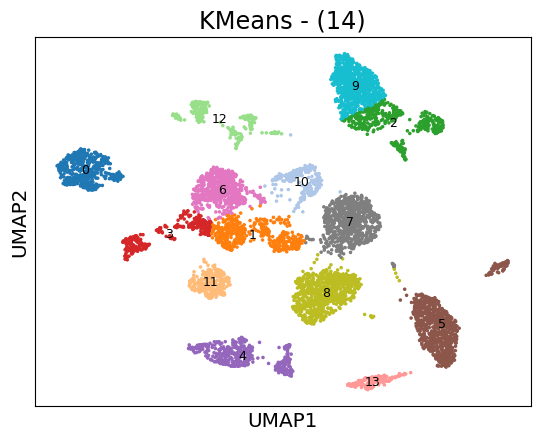

In [22]:
# Calculate the centroids of each cluster
cluster_centers = {}
for cluster_label in np.unique(clusters):
    # Get the indices for data points in this cluster
    indices = np.where(clusters == cluster_label)[0]
    # Calculate the centroid of this cluster
    cluster_center = np.mean(adata.obsm["X_umap"][indices, :], axis=0)
    cluster_centers[cluster_label] = cluster_center

# Plot the UMAP reduction and color by cluster
fig, ax = plt.subplots()
scprep.plot.scatter2d(adata.obsm["X_umap"], c=clusters,
                      title='{} - ({})'.format("KMeans", len(np.unique(clusters))),
                      ticks=False, label_prefix="UMAP", legend=False, discrete=True,
                      ax=ax)

# Annotate the cluster centroids
for cluster_label, centroid in cluster_centers.items():
    ax.annotate(str(cluster_label), centroid, fontsize=9, ha='center', va='center')

plt.show()

### 4.2 Utilising Jitterplots to find cluster charecterisitics

**Beta cells are marked by high expression of INS (insulin)**

<Axes: title={'center': 'INS'}, ylabel='INS'>

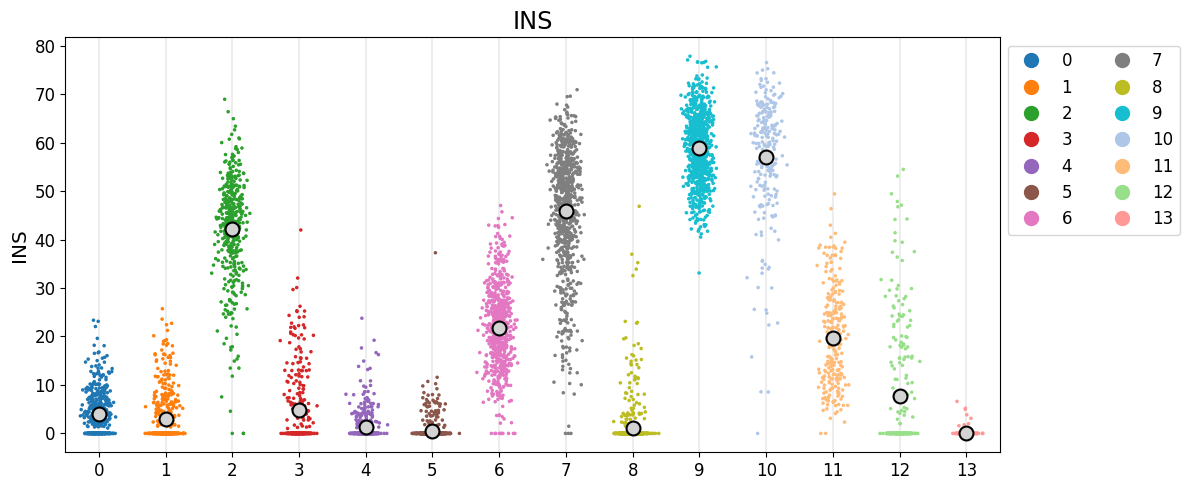

In [32]:
curr_gene = "INS"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

**Alpha cells are marked by high expression of GCG (glucagon)**

<Axes: title={'center': 'GCG'}, ylabel='GCG'>

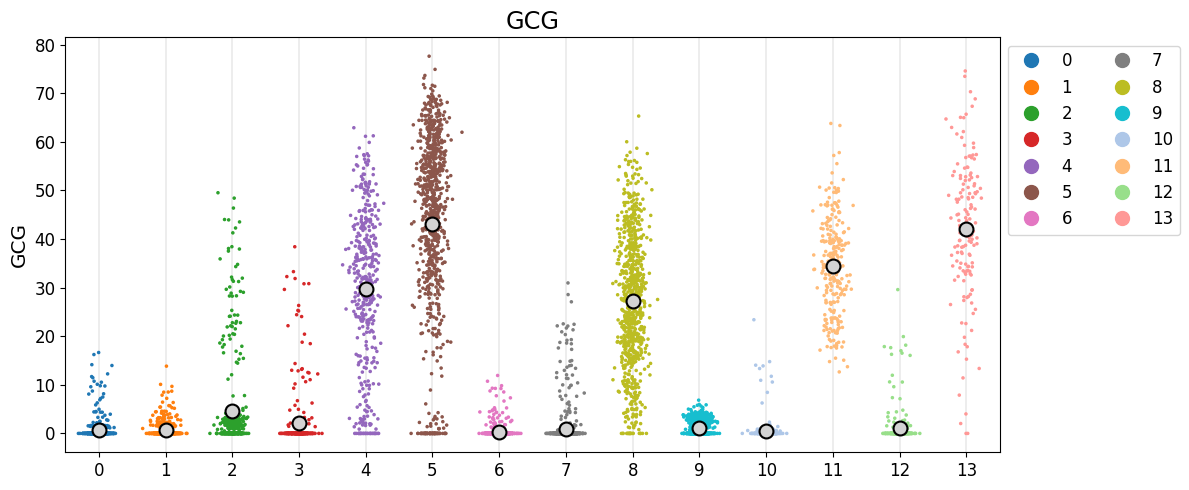

In [33]:
curr_gene = "GCG"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

**Delta cells are marked by high expression of SST (somatostatin)**

<Axes: title={'center': 'SST'}, ylabel='SST'>

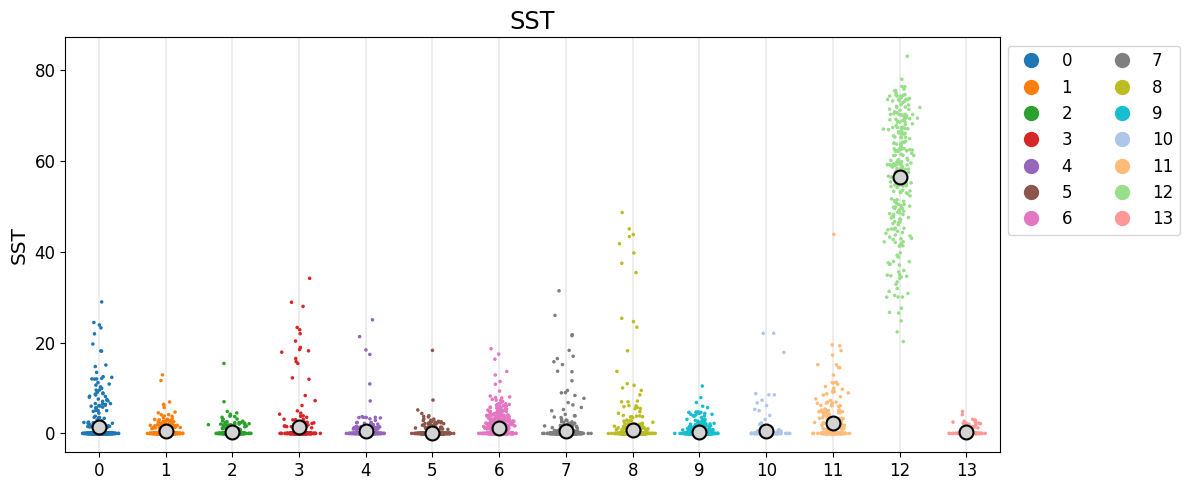

In [34]:
curr_gene = "SST"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

**Gamma cells are marked by high expression of PPY**

<Axes: title={'center': 'PPY'}, ylabel='PPY'>

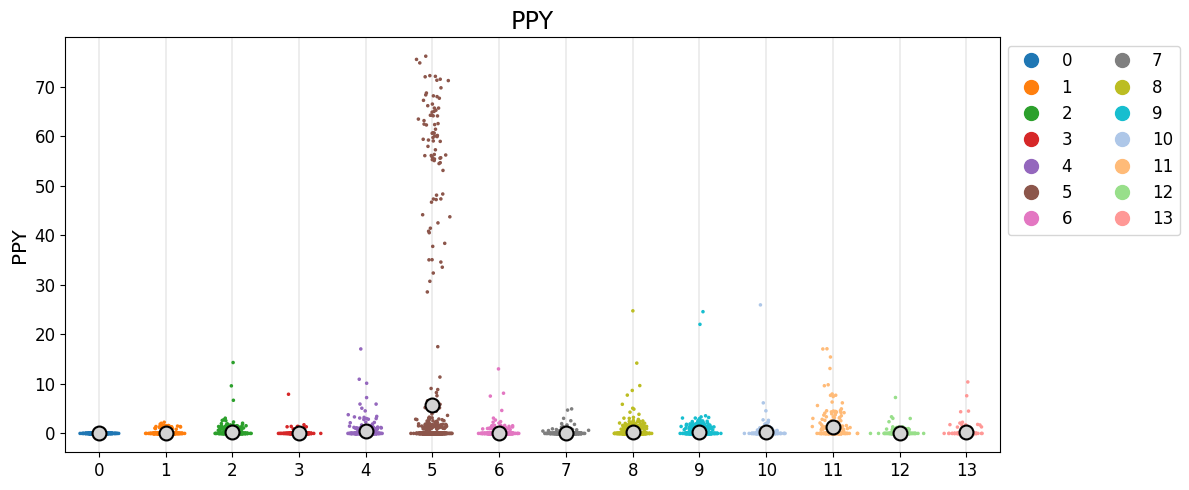

In [35]:
curr_gene = "PPY"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

**Genes Downregulated in Mature Cells Compared to Stem Cells, indicative of Stem Cells - CDC42 and ITGB1**

<Axes: title={'center': 'ITGB1'}, ylabel='ITGB1'>

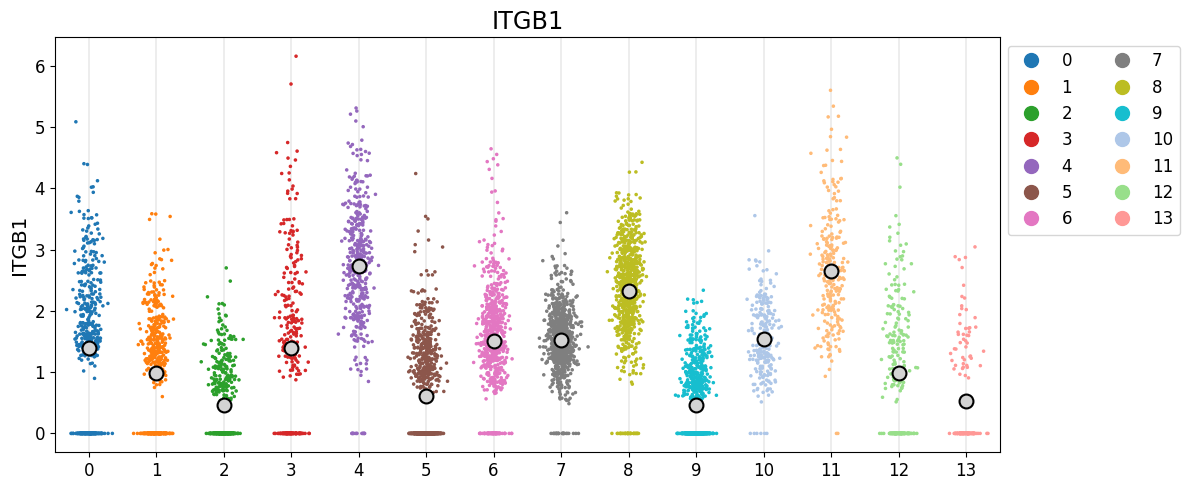

In [37]:
curr_gene = "ITGB1"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

<Axes: title={'center': 'SEMA3A'}, ylabel='SEMA3A'>

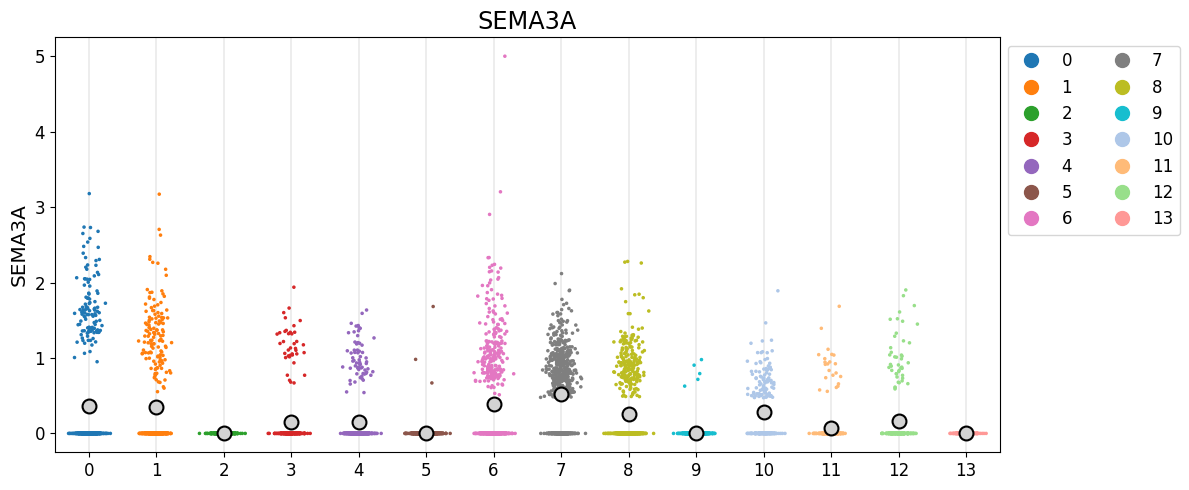

In [49]:
curr_gene = "SEMA3A"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

<Axes: title={'center': 'ROBO1'}, ylabel='ROBO1'>

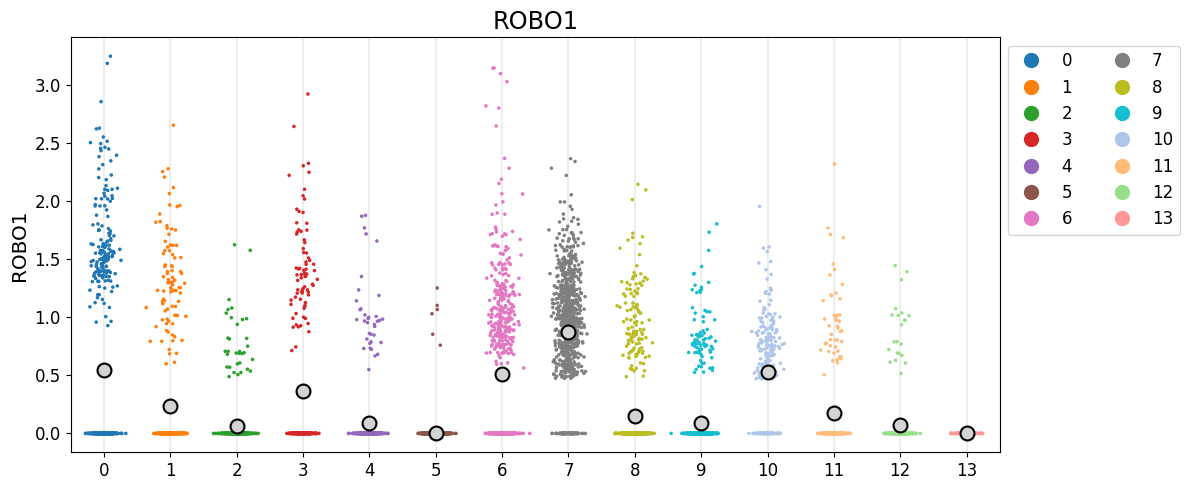

In [50]:
curr_gene = "ROBO1"
curr_expression = scprep.select.select_cols(data, exact_word=curr_gene)
scprep.plot.jitter(clusters, curr_expression, c=clusters, figsize=(12, 5),
                   legend_anchor=(1,1), title=curr_gene)

From these graphs we can deduce that cluster 3 and 13 having high INS (insulin expression) are probably representative of beta cells. Similarly we can form more conclusions as follows, the table below shows which clusters represent what cells:
| | INS (Beta Cells) | GCG (Alpha Cells) | Non INS/GCG (Stem Cells)| SST (Delta Cells) | PPY (Gamma Cells) | ITGB1 & SEMA3A (Stem Cells)|
|--|----------|----------|----------|----------|---|---|
|**Clusters**| 9,10,7,2 | 5,13,11 | 0,1,3,4,6,8,12 | 12 | 5 | 0,1,3,4,6,7,8,11 |


### 4.3 Differentially Expressed Genes

In [38]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [39]:
top_genes_list = []

for i in range(14):
    curr_cluster = i
    ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster],
                                                             data_sparse[clusters != curr_cluster],
                                                             measure='ttest')
    top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)
    top_genes_list.append([i, top_genes.head(n=5)])

/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-packages/scprep/stats.py:463: RuntimeWarning: invalid value encountered in true_divide
  return mean_difference(X, Y) / paired_std
/srv/conda/lib/python3.9/site-pack

In [40]:
top_genes_list

[[0,
  1
  PCSK1N     156.750769
  C4orf48    104.446519
  TTR         99.869570
  CLU         90.158292
  IFI6        82.646131
  Name: ttest, dtype: float64],
 [1,
  1
  TTR    56.976133
  GCG    52.653086
  CLU    51.764715
  INS    51.310002
  DDC    41.699068
  Name: ttest, dtype: float64],
 [2,
  1
  BASP1     64.638409
  MT-ND3    64.187404
  MARCKS    60.437414
  EVA1B     54.754385
  QPRT      52.114596
  Name: ttest, dtype: float64],
 [3,
  1
  G6PC2      52.369011
  TTR        46.431147
  FXYD2      45.366756
  SCGB2A1    45.194881
  SMIM24     43.614330
  Name: ttest, dtype: float64],
 [4,
  1
  INS       61.885484
  TUBB2B    55.147791
  FTL       52.049724
  TTR       51.147802
  UCHL1     45.324706
  Name: ttest, dtype: float64],
 [5,
  1
  MT-ND3     90.991433
  B2M        75.672311
  INS        73.807216
  MT-ATP6    68.739943
  MT-ND4L    67.646524
  Name: ttest, dtype: float64],
 [6,
  1
  MTRNR2L8    62.014673
  GCG         55.242593
  IGFBP7      48.262632
  ACVR1C

In [44]:
# Convert list to DataFrame
df_list = []
for cluster, genes in top_genes_list:
    temp_df = genes.to_frame(name='Value')
    temp_df['Gene'] = temp_df.index
    temp_df['Cluster'] = cluster
    df_list.append(temp_df)

# Concatenate all dataframes
top_genes_df = pd.concat(df_list).reset_index(drop=True)

# Reorder columns
top_genes_df = top_genes_df[['Cluster', 'Gene', 'Value']]

# Display the DataFrame
top_genes_df

Cluster     Gene       Value
0         0   PCSK1N  156.750769
1         0  C4orf48  104.446519
2         0      TTR   99.869570
3         0      CLU   90.158292
4         0     IFI6   82.646131
..      ...      ...         ...
65       13  C4orf48  138.041751
66       13   RPS4Y1  109.618333
67       13     H1FX   86.658538
68       13   PCSK1N   78.095347
69       13      INS   70.861543

[70 rows x 3 columns]

**Printing the 5 most differentially expressed genes in cluster n**

In [48]:
top_genes_df[top_genes_df['Cluster'] == 0]

Cluster     Gene       Value
0        0   PCSK1N  156.750769
1        0  C4orf48  104.446519
2        0      TTR   99.869570
3        0      CLU   90.158292
4        0     IFI6   82.646131

### 4.4 Inferencce

By looking at what genes are differentially expressed in which cluster group, I am able to hypothise what cell type each cluster might contain. From this table: 

| | INS (Beta Cells) | GCG (Alpha Cells) | Non INS/GCG (Stem Cells)| SST (Delta Cells) | PPY (Gamma Cells) | ITGB1 & SEMA3A (Stem Cells)|
|--|----------|----------|----------|----------|---|---|
|**Clusters**| 9,10,7,2 | 5,13,11 | 0,1,3,4,6,8,12 | 12 | 5 | 0,1,3,4,6,7,8,11 |

I can guess that:\
**Cluster groups 9, 10, 5, 13** showing high expression of INS and GCG have adult human pancreatic cells \
**Cluster groups 0, 1, 3, 4, 6, 8** are either stem cells or mouse engrafted cells but are definately not adult human pancreatic cells.

## 5. VERIFYING RESULTS

### 5.1 UMAP-KMeans vs. Cell-type Plot

<Axes: title={'center': 'KMeans'}, xlabel='UMAP1', ylabel='UMAP2'>

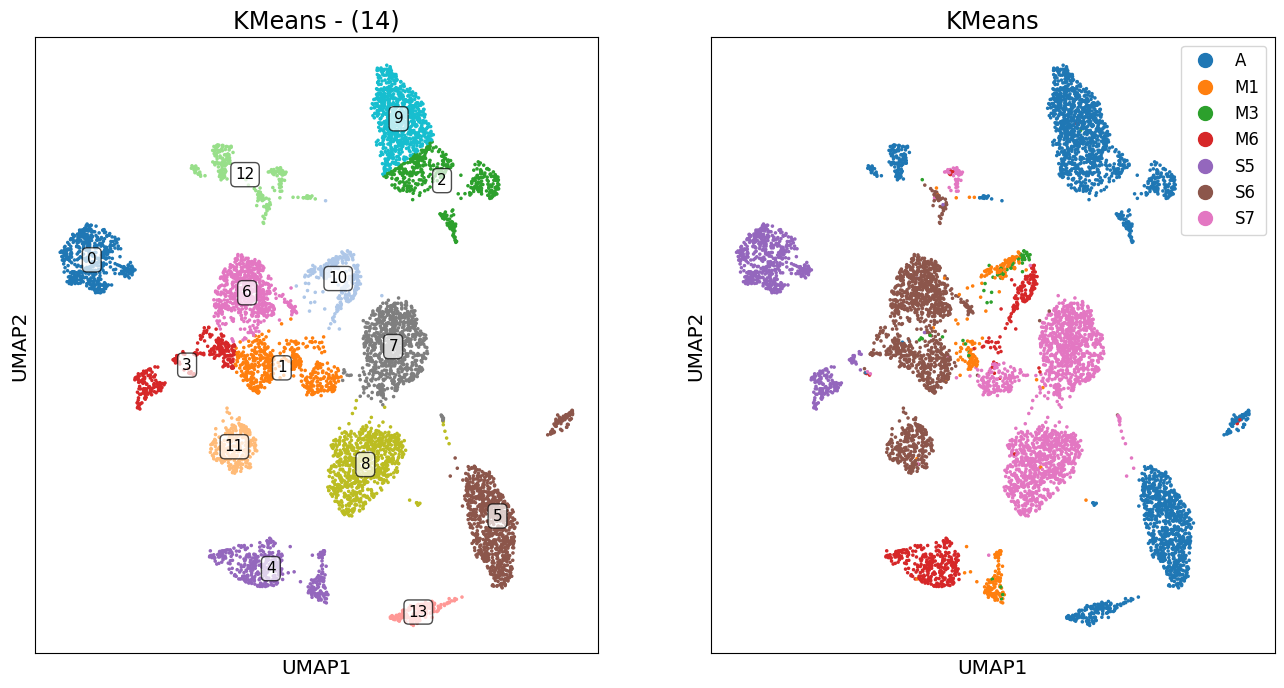

In [31]:
cluster_centers = {}
for cluster_label in np.unique(clusters):
    # Get the indices for data points in this cluster
    indices = np.where(clusters == cluster_label)[0]
    # Calculate the centroid of this cluster
    cluster_center = np.mean(adata.obsm["X_umap"][indices, :], axis=0)
    cluster_centers[cluster_label] = cluster_center
    
fig, axes = plt.subplots(1,2, figsize=(16,16), subplot_kw={'aspect':'equal'})

scprep.plot.scatter2d(adata.obsm["X_umap"], c=clusters,
                      title='{} - ({})'.format("KMeans", len(np.unique(clusters))),
                      ticks=False, label_prefix="UMAP", legend=False, discrete=True,
                      ax=axes[0])

# Annotate the cluster centroids
for cluster_label, centroid in cluster_centers.items():
    axes[0].annotate(str(cluster_label), centroid, fontsize=11, ha='center', va='center', 
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7))

scprep.plot.scatter2d(adata.obsm["X_umap"], c=metadata['celltype'],
                      title="KMeans",  
                      ticks=False, label_prefix="UMAP", legend=True, discrete=True,
                      ax=axes[1])

Hypothesis: \
**Cluster groups 9, 10, 5, 13** showing high expression of INS and GCG have adult human pancreatic cells \
**Cluster groups 0, 1, 3, 4, 6, 8** are either stem cells or mouse engrafted cells but are definately not adult human pancreatic cells 

Ground Truth: \
**Cluster groups 9, 2, 5, 13** are adult human pancreatic cells \
**Cluster groups 0, 1, 3, 4, 6, 7, 8, 10, 11** belong to stem cells or mouse engrafted cells 

So we got most of it right!

## 6. PAGA TRAJECTORY

### 6.1 Identifying Highly Variable Genes

In [51]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

### 6.2 Leiden Clusters

In [52]:
sc.tl.leiden(adata, resolution=0.5) #resolution reduced to get better grouped clusters

/srv/conda/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


/srv/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


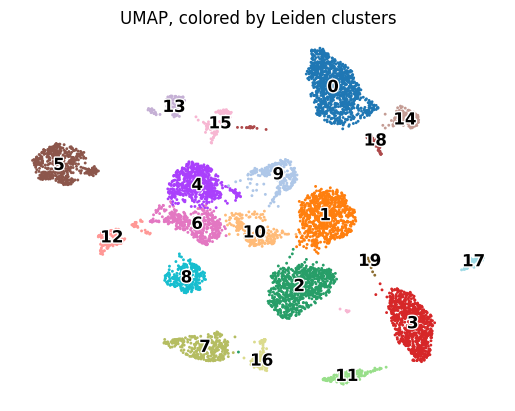

In [53]:
sc.pl.umap(adata, color='leiden', add_outline=False, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False,
           title='UMAP, colored by Leiden clusters')

### 6.3 Trajectory Inference

In [54]:
sc.tl.paga(adata)

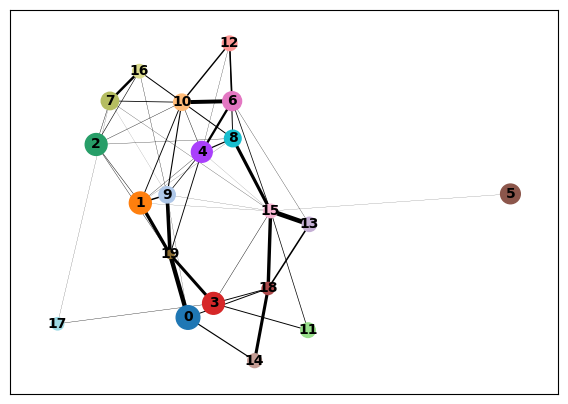

In [56]:
sc.pl.paga(adata, color=['leiden'])

**Compare PAGA with UMAP**

/srv/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


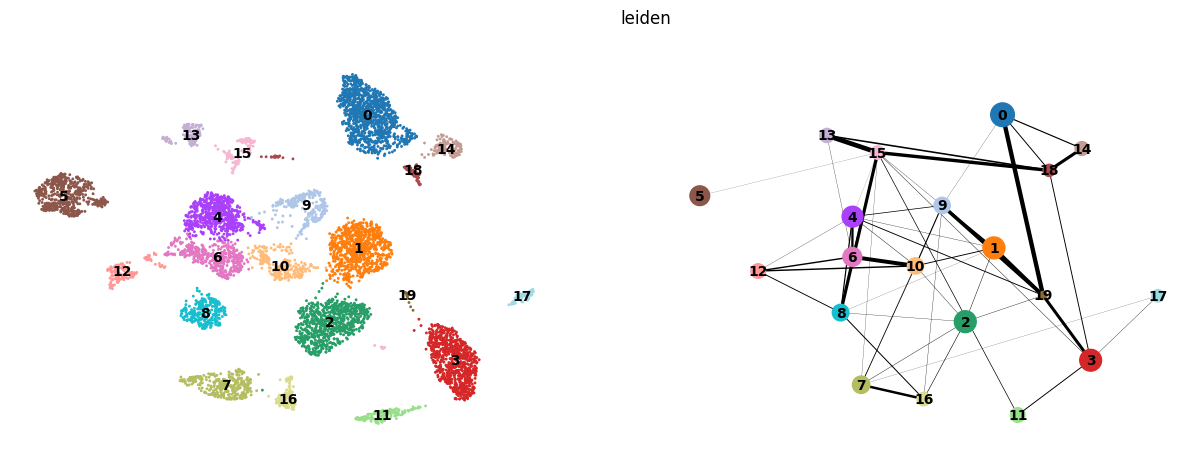

In [57]:
sc.pl.paga_compare(adata)

**Leiden clusters vs Cell Type**

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16), subplot_kw={'aspect': 'equal'})

sc.pl.umap(adata, color=['leiden', 'celltype'], add_outline=False, 
           legend_loc='on data', legend_fontsize=12, 
           legend_fontoutline=2, frameon=False,
           edges=True, 
           edges_width=0.5)

plt.savefig('figure.png')
plt.show()

/srv/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


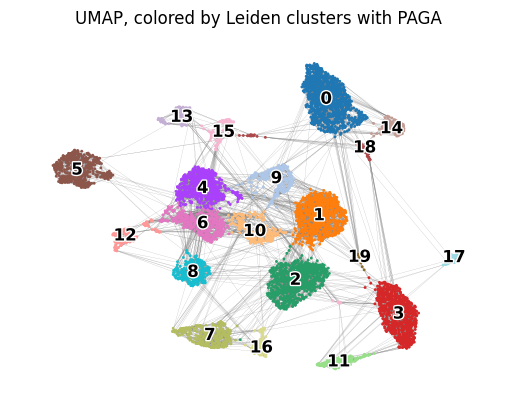

In [60]:
sc.pl.umap(adata, color='leiden', add_outline=False, 
           legend_loc='on data', legend_fontsize=12, 
           legend_fontoutline=2, frameon=False,
           title='UMAP, colored by Leiden clusters with PAGA', edges=True, 
           edges_width=0.1)